# Machine learning to predict energy consumption

## Introduction research

Energy transition is an important concept in today's society. Which also makes green energy generation very popular in the Netherlands. The top five most generating days with green energy also all took place in 2022. Unfortunately, there is also a downside to these spikes in energy production. Energy producers pay more for green energy towards the grid and grid operators have to pay a lot for huge peaks and troughs in the Netherlands' electricity grid. Besides this year has already seen five record spikes in green energy production. Alerts have also been issued by Tennet (manages high-voltage grid in the Netherlands) four times this year (Van Weezel, 2022). More on the stakeholders in this study, look at mine GitHub page: https://github.com/riksmink/HCAI-RoyalHaskoningDHV. 

So for both energy production companies and grid operators, it is very important to avoid these peaks and troughs. One way to do this is to forecast energy consumption (TNO, 2021). In this notebook, this is done based on a number of features. 

### The features for the prediction

The first feature is inflation. This is done because there is a strong link between inflation and buyer strength. Buyers strenght can decrease due to inflation. This is because a rising price level means that fewer products and services can be bought. Inflation and purchasing power affect the whole economy, from consumers to businesses (Hayes, 2022). Because of this relationship, inflation also affects long-term investment. Recently, energy prices have been rising rapidly the government also sees the link between sustained inflation, rising energy prices and falling purchasing power. Only to what extent does this relationship also affect energy consumption in the Netherlands and is there a relationship between the two (Tweede Kamer, 2022)?

The second feature is sunhours. First of all, sunshine hours means the total sunshine hours on a day in the Netherlands expressed in hours. In the Netherlands, there is a clear difference in the number of sunshine hours in summer and winter. In summer, the average number of sunshine hours is between 6 and 7 hours a day, while in winter it is 2 hours. Because there is less daylight in winter and it is more often cloudy in winter, the average is lower (Dirk Wolters, 2011).

When there are fewer sunlight hours, it means it is darker. As a result, people have to use energy more often (Visser, 2014) to provide themselves with light, by turning on lamps, for example. The number of sunshine hours also affects the use of green energy by solar panels. In summer, there are more hours of sunshine, so a lot of green energy can be generated. However, this will be used less because energy demand is higher in winter. It costs a lot of money to store solar energy to use later, which is therefore not done in households, for example. As a result, there is a higher peak energy consumption on the grid in winter (Visser, 2014).

The third feature is wind strenght. Wind force data are in FHEV. Vector average wind force of the day. The vector mean is the average of all vectors where the wind was blowing and how hard. If two vectors are exactly opposite each other, they cancel each other out and so does the wind force of the day. It is thus the average wind force in a given direction (KNMI, s.d.). Because of the large growth envisaged by the Netherlands in the use of wind energy as an energy source, this has also been included as a characteristic (Rijksoverheid, 2022).

The fourth characteristic is temperature. In a year where the average temperature is higher, energy consumption is lower. In a year where the temperature is lower, energy consumption is higher. This also means that the price of energy is higher, which has an important relationship with inflation (the first characteristic) (Het Weer, 2022). 

## Import packages

In [1]:
import pandas as pd
import numpy as np
import scipy.stats

import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Clean and prepare the datasets

A major drawback of this study is that only monthly energy data are available for the whole of the Netherlands. As a result, the other data also used in this study had to be converted into monthly data. But the second major drawback is that in another study on energy pridiction, the dataset of daily data was the most important thing in the study (Ding, 2020). The reason for including certain data is explained in more detail in the paper.

The legend describes the different characteristics of the dataset. The legend can be found at the bottom of the notebook. 

### Import the datasets

The dataset inflation_Netherlands is a dataset created in another Notebook. This Notebook is available on my GitHub page: https://github.com/riksmink/HCAI-RoyalHaskoningDHV. The other datasets are from: https://www.daggegevens.knmi.nl/klimatologie/daggegevens. 

In [2]:
inflation_Netherlands = pd.read_csv("Inflationfile.csv", skiprows = range(265, 273), index_col = False)
energy_consumption = pd.read_csv("MontlyEnergy.csv", skiprows = range(265, 273), index_col = 0)
sun_hours = pd.read_csv("zonuren1.csv", index_col = False)
temperature = pd.read_csv("Dataset_temperatuur.csv", skiprows = range(265, 274), index_col = False)
wind_mode = pd.read_csv("WeatherMontlyMode.csv", skiprows = range(265, 275), index_col = False)
wind_mean = pd.read_csv("WeatherMontlyAverage.csv", skiprows = range(265, 275), index_col = False)

### Work with the columns on the datasets

The first problem with the datasets is that there are different ways to write dates in the data. The second problem is that not all column names are in English. The third problem was that there were several columns that were not attributes for the ML model, so they were removed from the dataset. The reason for the removal of those columns is in another notebook. You can find this notebook at https://github.com/riksmink/HCAI-RoyalHaskoningDHV. 

#### Make a common date column

In [3]:
# Inflation dataset
import locale

# The months are in Netherlands in the dataset
locale.setlocale(locale.LC_ALL, "nl_NL")

inflation_Netherlands['Perioden'] = pd.to_datetime(inflation_Netherlands['Perioden'], format='%Y %B').apply(lambda date: date.strftime(format='%Y-%m'))

# Energy consumption dataset
energy_consumption['Perioden'] = pd.to_datetime(energy_consumption['Perioden'], format='%YMM%m').apply(lambda date: date.strftime(format='%Y-%m'))

# Sun hours dataset
sun_hours['Datum'] = pd.to_datetime(sun_hours['Datum'], format='%Y-%m').apply(lambda date: date.strftime(format='%Y-%m'))

# Temperature dataset
temperature['DateTime'] = pd.to_datetime(temperature['DateTime'], format='%Y-%m').apply(lambda date: date.strftime(format='%Y-%m'))

# Wind datasets
wind_mode['YYYYMMDD'] = pd.to_datetime(wind_mode['YYYYMMDD'], format='%Y-%m').apply(lambda date: date.strftime(format='%Y-%m'))
wind_mean['YYYYMMDD'] = pd.to_datetime(wind_mean['YYYYMMDD'], format='%Y-%m').apply(lambda date: date.strftime(format='%Y-%m'))

#### Rename the columns

In [4]:
# Inflation dataset
inflation_Netherlands01 = inflation_Netherlands.rename(columns={'Perioden': 'Date', 'CPI_energie' : 'CPI_energy'})

# Energy consumption dataset
energy_consumption01 = energy_consumption.rename(columns={'Perioden': 'Date', 'NettoVerbruikBerekend_30' : 'Energyconsumption'})

# Sun hours dataset
sun_hours01 = sun_hours.rename(columns={'Datum': 'Date', 'zonuren_dag' : 'Sunhoursdaily'})

# Temperature dataset
temperature01 = temperature.rename(columns={'DateTime': 'Date'})

# Wind datasets
wind_mode01 = wind_mode.rename(columns={'YYYYMMDD': 'Date'})
wind_mean01 = wind_mean.rename(columns={'YYYYMMDD': 'Date'})


#### Drop some columns

In [5]:
# Inflation dataset
inflation_Netherlands02 = inflation_Netherlands01.drop(['Jaar', 'Maand', 'CPI_energie-100', 'CPI_energiejaarlijks', 'CPI_algemeen', 'CPI(afgeleid)_energie ','CPI(algemeen)_afgeleid', 'CPI_elektriciteit', 'CPI(elektriciteit)_afgeleid', 'CPI_gas', 'CPI(gas)_afgeleid'], axis=1)

# Energy dataset
energy_consumption02 = energy_consumption01.drop(['ID'], axis=1)

# Temperature dataset
temperature02 = temperature01.drop(['Unnamed: 0'], axis=1)

### Merge the datasets and prepare for machine learning

The preparation for merging is done. Now the datasets are prepared for training the models for machine learning.  Time series is very important because the model is gonna predict a continuous variable in the feature (Knaub, 2015). 

#### Merge the datasets

In [6]:
# merge all the dataframes
ml_datasetenergy = inflation_Netherlands02.merge(energy_consumption02, on='Date', how='left').merge(sun_hours01, on='Date', how='left').merge(temperature02, on='Date', how='left').merge(wind_mode01, on='Date', how='left').merge(wind_mean01, on='Date', how='left')

# Show new dataframe
ml_datasetenergy.head()

,Date,CPI_energy,Energyconsumption,Sunhoursdaily,TG,TN,TX,FG_x,FG_y
0,2000-01,52.22,8847,1.806452,4.329032,1.729032,6.561290,4.0,4.219355
1,2000-02,52.29,8235,3.682759,5.855172,2.537931,8.941379,4.6,4.748276
2,2000-03,52.73,8738,2.583871,6.796774,3.361290,10.112903,1.5,3.980645
3,2000-04,52.74,7912,5.116667,9.986667,5.186667,14.753333,1.9,3.553333
4,2000-05,52.74,8221,6.780645,14.732258,9.274194,20.022581,3.8,3.496774


#### Create new columns in the dataframe for working with time series 

For working with time-related data, it is important to take this relationship into account. After all, forecasts cannot be made based on data in the same month. In addition, with energy data it is difficult to forecast with 1 month in the past. The reason for this is that then the calculation of the forecast in the first month must all take place. The choice of the 1 year, 2 months is because of the weather features (Knaub, 2015).

In [7]:
# Copy the date column and make a new one

# 2 months
ml_datasetenergy ['CPI_energy2month'] = ml_datasetenergy ['CPI_energy']
ml_datasetenergy ['Sunhoursdaily2month'] = ml_datasetenergy ['Sunhoursdaily']
ml_datasetenergy ['TG2month'] = ml_datasetenergy ['TG']
ml_datasetenergy ['TX2month'] = ml_datasetenergy ['TG']
ml_datasetenergy ['TN2month'] = ml_datasetenergy ['TN']
ml_datasetenergy ['FG_x2month'] = ml_datasetenergy ['FG_x']
ml_datasetenergy ['FG_y2month'] = ml_datasetenergy ['FG_y']

# 3 months
ml_datasetenergy ['CPI_energy3month'] = ml_datasetenergy ['CPI_energy']
ml_datasetenergy ['Sunhoursdaily3month'] = ml_datasetenergy ['Sunhoursdaily']
ml_datasetenergy ['TG3month'] = ml_datasetenergy ['TG']
ml_datasetenergy ['TX3month'] = ml_datasetenergy ['TX']
ml_datasetenergy ['TN3month'] = ml_datasetenergy ['TN']
ml_datasetenergy ['FG_x3month'] = ml_datasetenergy ['FG_x']
ml_datasetenergy ['FG_y3month'] = ml_datasetenergy ['FG_y']

# 6 months
ml_datasetenergy ['CPI_energy6month'] = ml_datasetenergy ['CPI_energy']
ml_datasetenergy ['Sunhoursdaily6month'] = ml_datasetenergy ['Sunhoursdaily']
ml_datasetenergy ['TG6month'] = ml_datasetenergy ['TG']
ml_datasetenergy ['TX6month'] = ml_datasetenergy ['TX']
ml_datasetenergy ['TN6month'] = ml_datasetenergy ['TN']
ml_datasetenergy ['FG_x6month'] = ml_datasetenergy ['FG_x']
ml_datasetenergy ['FG_y6month'] = ml_datasetenergy ['FG_y']

# 1 year
ml_datasetenergy ['CPI_energy1year'] = ml_datasetenergy ['CPI_energy']
ml_datasetenergy ['Sunhoursdaily1year'] = ml_datasetenergy ['Sunhoursdaily']
ml_datasetenergy ['TG1year'] = ml_datasetenergy ['TG']
ml_datasetenergy ['TX1year'] = ml_datasetenergy ['TX']
ml_datasetenergy ['TN1year'] = ml_datasetenergy ['TN']
ml_datasetenergy ['FG_x1year'] = ml_datasetenergy ['FG_x']
ml_datasetenergy ['FG_y1year'] = ml_datasetenergy ['FG_y']

# Move the rows in the column

# 2 months
ml_datasetenergy ['CPI_energy2month'] = ml_datasetenergy ['CPI_energy2month'].shift(+2)
ml_datasetenergy ['Sunhoursdaily2month'] = ml_datasetenergy ['Sunhoursdaily2month'].shift(+2)
ml_datasetenergy ['TG2month'] = ml_datasetenergy ['TG2month'].shift(+2)
ml_datasetenergy ['TX2month'] = ml_datasetenergy ['TX2month'].shift(+2)
ml_datasetenergy ['TN2month'] = ml_datasetenergy ['TN2month'].shift(+1)
ml_datasetenergy ['FG_x2month'] = ml_datasetenergy ['FG_x2month'].shift(+2)
ml_datasetenergy ['FG_y2month'] = ml_datasetenergy ['FG_y2month'].shift(+2)

# 3 month
ml_datasetenergy ['CPI_energy3month'] = ml_datasetenergy ['CPI_energy3month'].shift(+3)
ml_datasetenergy ['Sunhoursdaily3month'] = ml_datasetenergy ['Sunhoursdaily3month'].shift(+3)
ml_datasetenergy ['TG3month'] = ml_datasetenergy ['TG3month'].shift(+3)
ml_datasetenergy ['TX3month'] = ml_datasetenergy ['TX3month'].shift(+3)
ml_datasetenergy ['TN3month'] = ml_datasetenergy ['TN3month'].shift(+3)
ml_datasetenergy ['FG_x3month'] = ml_datasetenergy ['FG_x3month'].shift(+3)
ml_datasetenergy ['FG_y3month'] = ml_datasetenergy ['FG_y3month'].shift(+3)

# 6 month
ml_datasetenergy ['CPI_energy6month'] = ml_datasetenergy ['CPI_energy6month'].shift(+6)
ml_datasetenergy ['Sunhoursdaily6month'] = ml_datasetenergy ['Sunhoursdaily6month'].shift(+6)
ml_datasetenergy ['TG6month'] = ml_datasetenergy ['TG6month'].shift(+6)
ml_datasetenergy ['TX6month'] = ml_datasetenergy ['TX6month'].shift(+6)
ml_datasetenergy ['TN6month'] = ml_datasetenergy ['TN6month'].shift(+6)
ml_datasetenergy ['FG_x6month'] = ml_datasetenergy ['FG_x6month'].shift(+6)
ml_datasetenergy ['FG_y6month'] = ml_datasetenergy ['FG_y6month'].shift(+6)

# 1 year
ml_datasetenergy ['CPI_energy1year'] = ml_datasetenergy ['CPI_energy1year'].shift(+12)
ml_datasetenergy ['Sunhoursdaily1year'] = ml_datasetenergy ['Sunhoursdaily1year'].shift(+12)
ml_datasetenergy ['TG1year'] = ml_datasetenergy ['TG1year'].shift(+12)
ml_datasetenergy ['TX1year'] = ml_datasetenergy ['TX1year'].shift(+12)
ml_datasetenergy ['TN1year'] = ml_datasetenergy ['TN1year'].shift(+12)
ml_datasetenergy ['FG_x1year'] = ml_datasetenergy ['FG_x1year'].shift(+12)
ml_datasetenergy ['FG_y1year'] = ml_datasetenergy ['FG_y1year'].shift(+12)

In [8]:
# The target variable as feature for ml-model

# 2, 3 and 6 months and 1 year
ml_datasetenergy ['Energyconsumption2month'] = ml_datasetenergy ['Energyconsumption']
ml_datasetenergy ['Energyconsumption3month'] = ml_datasetenergy ['Energyconsumption']
ml_datasetenergy ['Energyconsumption6month'] = ml_datasetenergy ['Energyconsumption']
ml_datasetenergy ['Energyconsumption1year'] = ml_datasetenergy ['Energyconsumption']

# Move the rows in the column
ml_datasetenergy ['Energyconsumption2month'] = ml_datasetenergy ['Energyconsumption2month'].shift(+1)
ml_datasetenergy ['Energyconsumption3month'] = ml_datasetenergy ['Energyconsumption3month'].shift(+3)
ml_datasetenergy ['Energyconsumption6month'] = ml_datasetenergy ['Energyconsumption6month'].shift(+6)
ml_datasetenergy ['Energyconsumption1year'] = ml_datasetenergy ['Energyconsumption1year'].shift(+12)

In [9]:
# Make a new dataframe without the NAN values
ml_datasetenergy01 = ml_datasetenergy.copy()
ml_datasetenergy01 = ml_datasetenergy01.drop(labels=range(0,12), axis=0) # Range 0-12 because of the shift +12

ml_datasetenergy01.columns = ml_datasetenergy01.columns.str.strip()

ml_datasetenergy01.head()

,Date,CPI_energy,Energyconsumption,Sunhoursdaily,TG,TN,TX,FG_x,FG_y,CPI_energy2month,...,Sunhoursdaily1year,TG1year,TX1year,TN1year,FG_x1year,FG_y1year,Energyconsumption2month,Energyconsumption3month,Energyconsumption6month,Energyconsumption1year
12,2001-01,62.13,9267,2.312903,2.606452,0.025806,5.332258,1.3,3.693548,55.08,...,1.806452,4.329032,6.561290,1.729032,4.0,4.219355,8844.0,8749.0,8006.0,8847.0
13,2001-02,62.13,8266,3.260714,4.467857,1.153571,7.792857,3.5,3.639286,55.08,...,3.682759,5.855172,8.941379,2.537931,4.6,4.748276,9267.0,8892.0,8119.0,8235.0
14,2001-03,62.13,8962,2.041935,4.945161,1.835484,8.032258,3.3,3.829032,62.13,...,2.583871,6.796774,10.112903,3.361290,1.5,3.980645,8266.0,8844.0,8217.0,8738.0
15,2001-04,60.14,8156,4.830000,8.283333,4.090000,12.580000,3.5,3.926667,62.13,...,5.116667,9.986667,14.753333,5.186667,1.9,3.553333,8962.0,9267.0,8749.0,7912.0
16,2001-05,60.14,8304,8.941935,14.141935,8.522581,19.358065,4.0,3.835484,62.13,...,6.780645,14.732258,20.022581,9.274194,3.8,3.496774,8156.0,8266.0,8892.0,8221.0


#### Split the 'Date' column in a in a year and month column

In [10]:
# Split the date column in year and month columns because some ML-models work better that way 
ml_datasetenergy01[["Year", "Month"]] = ml_datasetenergy01["Date"].str.split("-", expand = True)

# Make the year and month columns digits
ml_datasetenergy01 ['Year'] = ml_datasetenergy01['Year'].str.extract('(\d+)', expand=False).astype(int)
ml_datasetenergy01 ['Month'] = ml_datasetenergy01['Month'].str.extract('(\d+)', expand=False).astype(int)

# Copy
ml_datasetenergy02 = ml_datasetenergy01.copy()

# Show the new dataframe
ml_datasetenergy02.head()

,Date,CPI_energy,Energyconsumption,Sunhoursdaily,TG,TN,TX,FG_x,FG_y,CPI_energy2month,...,TX1year,TN1year,FG_x1year,FG_y1year,Energyconsumption2month,Energyconsumption3month,Energyconsumption6month,Energyconsumption1year,Year,Month
12,2001-01,62.13,9267,2.312903,2.606452,0.025806,5.332258,1.3,3.693548,55.08,...,6.561290,1.729032,4.0,4.219355,8844.0,8749.0,8006.0,8847.0,2001,1
13,2001-02,62.13,8266,3.260714,4.467857,1.153571,7.792857,3.5,3.639286,55.08,...,8.941379,2.537931,4.6,4.748276,9267.0,8892.0,8119.0,8235.0,2001,2
14,2001-03,62.13,8962,2.041935,4.945161,1.835484,8.032258,3.3,3.829032,62.13,...,10.112903,3.361290,1.5,3.980645,8266.0,8844.0,8217.0,8738.0,2001,3
15,2001-04,60.14,8156,4.830000,8.283333,4.090000,12.580000,3.5,3.926667,62.13,...,14.753333,5.186667,1.9,3.553333,8962.0,9267.0,8749.0,7912.0,2001,4
16,2001-05,60.14,8304,8.941935,14.141935,8.522581,19.358065,4.0,3.835484,62.13,...,20.022581,9.274194,3.8,3.496774,8156.0,8266.0,8892.0,8221.0,2001,5


### Save the dataset as a 'csv file'

In [11]:
ml_datasetenergy02.to_csv('datasetenergyprediction')

## Visualate the relations in the dataset

Visualising data is very important. This is because it allows, for instance, patterns or outliers in the dataset to become visible. Which in turn allows certain trends to be visualised (Tableau, s.d.). An important part of the study was to demonstrate the relationship between trends and energy consumption. This is done based on correlation calculations and these are also made visible in a scatterplot. Correlation shows the relationship between a feature and a target variable (Menon, 2022). 

### Scatterplot with random column

Run the next cell again for another plot with a different column (feature) from the dataset. The scatterplot shows the relationship between a random feature and the target variable. 

#### The visualisation

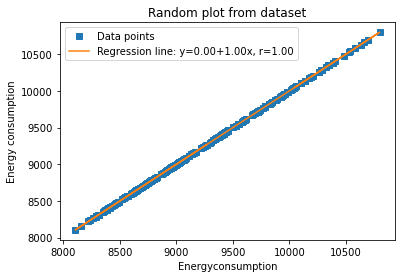

In [12]:
# Make a random column generator
rnd_col = rnd.choice(ml_datasetenergy02.columns)

# Give the x and y
x = ml_datasetenergy02[rnd_col]
y = ml_datasetenergy02['Energyconsumption']

# Make a regression line from the Pearson correlation coefficient
slope, intercept, r, p, stderr = scipy.stats.linregress(x, y)

# Relation between the regression line and the value of the correlation coefficient
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'
line

# Make the plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel(rnd_col)
ax.set_ylabel('Energy consumption')
ax.legend(facecolor='white')

plt.title("Random plot from dataset")
plt.show()

## Machine learning

Regression models are used for prediction for two reasons. Regression is necessary because the target variable is continuous. It is also not possible to create a neural network because it is a black box and cannot say anything about the characteristics which was a key requirement of the client (Ying, 2021). 

The machine learning model for prediction is measured in two ways. First, it looks at the mean squared error. The mean squared error assesses the average squared difference between the observed and predicted values (Jim Frost, z.d.). This is important for the study because it should be as low as possible. The number of KwH wrongly predicted is the lower, the better. 

We also look at the R-squared. That is a statistical way of representing the proportion of variance for a dependent variable so that it is explained by an independent variable or variables in a regression model. In the case of the study, it should be high because the relationship between the target variable and the features is very important  (Fernando, 2021). 

### Prediction based on the energyconsumption of the year before (no machine learning)

the scatterplot above shows that there is a strong correlation (0.93) between energy consumption and time series energy consumption a year ago. This relationship is explored further below. This is done based on the mean squared error (further explained above). 

First, we look at the mean squared error per month based on the same month in that previous year over the data of the past 21 years. This is calculated for each month. An average is then calculated from this. 

The resulting mean squared error is leading for the conclusions that can be drawn from the operation of the machine learning model. Namely, it means that it must be lower than what comes out of this calculation. Otherwise, better predictions can be made just based on the same month the year before. 

#### Calculation 

In [13]:
# Make dataframes of the months
january_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 1]
february_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 2]
march_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 3]
april_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 4]
may_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 5]
june_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 6]
july_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 7]
august_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 8]
september_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 9]
october_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 10]
november_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 11]
december_prediction = ml_datasetenergy02[ml_datasetenergy02['Month'] == 12]


# Calculate the mean
january_prediction01 = np.mean(np.sqrt((january_prediction['Energyconsumption'] - january_prediction['Energyconsumption1year'])**2))
february_prediction01 = np.mean(np.sqrt((february_prediction['Energyconsumption'] - february_prediction['Energyconsumption1year'])**2))
march_prediction01 = np.mean(np.sqrt((march_prediction['Energyconsumption'] - march_prediction['Energyconsumption1year'])**2))
april_prediction01 = np.mean(np.sqrt((april_prediction['Energyconsumption'] - april_prediction['Energyconsumption1year'])**2))
may_prediction01 = np.mean(np.sqrt((may_prediction['Energyconsumption'] - may_prediction['Energyconsumption1year'])**2))
june_prediction01 = np.mean(np.sqrt((june_prediction['Energyconsumption'] - june_prediction['Energyconsumption1year'])**2))
july_prediction01 = np.mean(np.sqrt((july_prediction['Energyconsumption'] - july_prediction['Energyconsumption1year'])**2))
august_prediction01 = np.mean(np.sqrt((august_prediction['Energyconsumption'] - august_prediction['Energyconsumption1year'])**2))
september_prediction01 = np.mean(np.sqrt((september_prediction['Energyconsumption'] - september_prediction['Energyconsumption1year'])**2))
october_prediction01 = np.mean(np.sqrt((october_prediction['Energyconsumption'] - october_prediction['Energyconsumption1year'])**2))
november_prediction01 = np.mean(np.sqrt((november_prediction['Energyconsumption'] - november_prediction['Energyconsumption1year'])**2))
december_prediction01 = np.mean(np.sqrt((december_prediction['Energyconsumption'] - december_prediction['Energyconsumption1year'])**2))

# Make an dataframe of the total mean
total_mean = [january_prediction01, february_prediction01, march_prediction01, april_prediction01, may_prediction01, june_prediction01, july_prediction01, august_prediction01, september_prediction01, october_prediction01, november_prediction01, december_prediction01]

# Make a mean of all the predictions
prediction_based_on_last_year = sum(total_mean)/12

# Show the result
prediction_based_on_last_year

198.24603174603178

#### Conclusion prediction based on last year

The mean squared error of the model should be less than 198.25. This means that the model is better than a simple prediction based on the previous year. The best month to predict based on the previous year is September. The worst month is January. 

### Feature selection for the  regression model

A paper on effective features to predict energy consumption says that a key input for machine learning models to predict energy consumption is feature selection. This improves prediction performance and it helps researchers better understand the underlying process (Zhao, 2019).

#### What happens in feature selection? 

Regression used to be used only when predicting the target variable. Only now it can be used in some cases to determine causal relations between the independent and dependent variables. The second happens in feature selection (Maulud, 2020). 

The dataset contains 32 features. These are the input variables for machine learning models. To train the model, it is important that the essential features are in the model. This does not mean that all features from the dataset are essential. Feature selection allows the model to learn unimportant patterns and learn from noise. If the noise is in the model, the output of the model is also not good. Feature selection does not change the feature. It only looks at those that are important as inputs to the model. Since the input variables are numeric and so is the output variable, the best feature selection method is correlation (Menon, 2022). 

#### Correlation feature selection

The machine learning models choice is regression (Ying, 2021). In most regression models, the correlation between the target variable and the characteristics is important. The stronger the correlation, the stronger the model. Therefore, a correlation characteristic is selected first. A higher score means a stronger correlation with the target variable (Brownlee, 2020). 

Feature 0: CPI_energy1year - 19.395095
Feature 1: Sunhoursdaily1year - 124.939985
Feature 2: TG1year - 107.228075
Feature 3: TX1year - 127.563694
Feature 4: TN1year - 79.536614
Feature 5: FG_x1year - 2.293997
Feature 6: FG_y1year - 35.522787
Feature 7: CPI_energy2month - 13.339460
Feature 8: Sunhoursdaily2month - 32.806360
Feature 9: TG2month - 1.093218
Feature 10: TX2month - 1.093218
Feature 11: TN2month - 25.823847
Feature 12: FG_x2month - 0.390140
Feature 13: FG_y2month - 0.195177
Feature 14: CPI_energy3month - 10.563973
Feature 15: Sunhoursdaily3month - 0.557879
Feature 16: TG3month - 14.649105
Feature 17: TX3month - 11.488363
Feature 18: TN3month - 22.584469
Feature 19: FG_x3month - 1.918701
Feature 20: FG_y3month - 11.343410
Feature 21: CPI_energy6month - 15.018424
Feature 22: Sunhoursdaily6month - 98.775683
Feature 23: TG6month - 127.543926
Feature 24: TX6month - 126.755391
Feature 25: TN6month - 111.220456
Feature 26: FG_x6month - 0.940306
Feature 27: FG_y6month - 26.642842
Fea

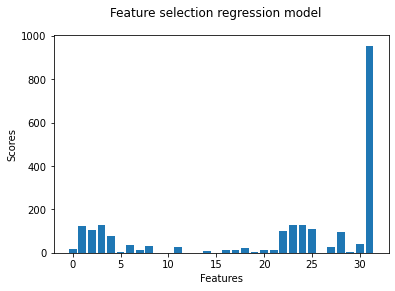

In [14]:
# Import new packages 
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Make a x and y from the dataset
x = ml_datasetenergy02[['CPI_energy1year', 'Sunhoursdaily1year', 'TG1year', 'TX1year', 'TN1year','FG_x1year','FG_y1year', 'CPI_energy2month', 'Sunhoursdaily2month', 'TG2month', 'TX2month', 'TN2month', 'FG_x2month', 'FG_y2month', 'CPI_energy3month', 'Sunhoursdaily3month', 'TG3month', 'TX3month', 'TN3month', 'FG_x3month', 'FG_y3month', 'CPI_energy6month', 'Sunhoursdaily6month', 'TG6month', 'TX6month', 'TN6month', 'FG_x6month', 'FG_y6month','Energyconsumption2month', 'Energyconsumption3month', 'Energyconsumption6month','Energyconsumption1year']]
y = ml_datasetenergy02['Energyconsumption']

# Split the dataset in training- and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

# Make the regressionmodel 
regressionmodel = LinearRegression() # Make the linear regressionmodel
regressionmodel.fit(x_train, y_train) # Fit the model

# Define the feature selection 
def select_features(x_train, y_train, x_test):
    feature_selection = SelectKBest(score_func=f_regression, k='all') # Get all the features from the dataset
    feature_selection.fit(x_train, y_train) # Important: see the relationship (learning) in the training data
    x_train_feature_selection = feature_selection.transform(x_train) # convert the train input data
    x_test_feature_selection = feature_selection.transform(x_test)   # convert the test input data
    return x_train_feature_selection, x_test_feature_selection, feature_selection # Return the converted data

# Get the feature selection
x_train_feature_selection, x_test_feature_selection, feature_selection = select_features(x_train, y_train, x_test)

# Get the scores of the features   
for columns, score, i in zip(x.columns, feature_selection.scores_, range(len(feature_selection.scores_))): # Create a zip because of the multiple variables
    print('Feature %d: %s - %f' % (i, columns, score)) # Print as Feature, number of feature (0-31), feature name and score

# Show the scores in a plot
fig = plt.figure() # Make a figure

plt.bar([i for i in range(len(feature_selection.scores_))], feature_selection.scores_) # Create a function in the plotbar that shows the scores and the number of the feature. 

# Specify the figure
fig.suptitle('Feature selection regression model')
plt.xlabel('Features')
plt.ylabel('Scores')

plt.show()


#### How much features in the model? 

Now that it is clear which features have a higher correlation with the target variable, it is important to calculate how many features are included in the model. This is called a grid search. In this grid search the k argument to the SelectKBest class can be tuned (Brownlee, 2020).

In the calculation there is used a 'pipeline'. Pipelines can be used for feature selection, helping to improve accuracy by eliminating the unnecessary or least important features (Peri, 2019). The function that will use this calculation for the pipeline is SelectKbest (see above). Cross-validation can be done on the pipeline (Peri, 2019). This is the GridSearchCV in the calculation. 

In [15]:
# Import new packages
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define the evaluation method. Chose for cross validation. Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample (Brownlee, 2018. 
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1) # 

# Define the pipeline to evaluate. Prepares the feature selection transform on the training set and applies it to the train set and test set for each fold of the cross-validation.
model_feature_selection = LinearRegression()
method_feature_selection = SelectKBest(score_func=mutual_info_regression)
pipeline = Pipeline(steps=[('sel',method_feature_selection), ('lr', model_feature_selection)]) # Also defined a name 'sel'

# Make the grid
grid = dict()
grid['sel__k'] = [i for i in range(x.shape[1]-20, x.shape[1]+1)] # Can access it because of the name (sel)

# Make the grid search. The score becomes negative because of the scikit-learn packages use. 
search_feature_selection = GridSearchCV(pipeline, grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv) # Score needs to be maximized

# Create the search
results_feature_selection = search_feature_selection.fit(x, y) # Looks at the performance

# Make a selection of the best
print('Best MAE: %.3f' % results_feature_selection .best_score_) # Looks at the best MAE
print('Best Config: %s' % results_feature_selection .best_params_) # Looks at the config

# Make a summarized selection of all
means_feature_selection = results_feature_selection.cv_results_['mean_test_score'] 
params_feature_selection = results_feature_selection.cv_results_['params']

# Show the selection
for mean_feature_selection, params_feature_selection in zip(means_feature_selection, params_feature_selection): # Create a zip because of the multiple variables
    print(">%.3f with: %r" % (mean_feature_selection, params_feature_selection)) #  Shows the combination of the best outcomes from the calculation

Best MAE: -52174.016
Best Config: {'sel__k': 16}
>-53860.149 with: {'sel__k': 12}
>-53937.913 with: {'sel__k': 13}
>-52677.332 with: {'sel__k': 14}
>-52354.914 with: {'sel__k': 15}
>-52174.016 with: {'sel__k': 16}
>-52410.106 with: {'sel__k': 17}
>-52712.404 with: {'sel__k': 18}
>-52504.291 with: {'sel__k': 19}
>-52545.437 with: {'sel__k': 20}
>-53116.916 with: {'sel__k': 21}
>-53433.007 with: {'sel__k': 22}
>-53655.258 with: {'sel__k': 23}
>-53905.967 with: {'sel__k': 24}
>-53616.518 with: {'sel__k': 25}
>-54681.733 with: {'sel__k': 26}
>-55093.996 with: {'sel__k': 27}
>-55429.602 with: {'sel__k': 28}
>-56484.130 with: {'sel__k': 29}
>-56509.529 with: {'sel__k': 30}
>-56754.079 with: {'sel__k': 31}
>-56921.625 with: {'sel__k': 32}


#### Conclusion from feature selection

The first key finding is that there is a very high correlation between the target variable and the previous year's feature energy consumption. Much higher than the rest of the features. But the second conclusion is that the ideal number of features is 17, so the best 17 features are included in the machine learning model. These are the features below in order of high to low score.
                     
1. Energyconsumption1year
2. TX1year               
3. TG6month              
4. TX6month
5. Sunhoursdaily1year
6. TN6month
7. TG1year
8. Sunhoursdaily6month
9. Energyconsumption2month
10. TN1year
11. Energyconsumption6month
12. FG_y1year
13. Sunhoursdaily2month
14. FG_y6month
15. TN2month
16. TN3month
17. CPI_energy1year

### Linear regression

Linear regression is a widely used technique to predict a target variable. The first main purpose of linear regression is to examine which features have strong relationships with the target variable (StatisticsSolutions, z.d.). This was shown in the previous chapter. Now a prediction is made based on linear regression. What is the most commonly used technique of machine learning with regression (Maulud, 2020).   

The purpose of this chapter is to calculate whether these features can predict the target variable well based on linear regression. In addition, linear regression is also applied with all features. This allows to see whether the feature selection has optimised the model. 

#### Predict with the 17 best features

In [16]:
# Import packages
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Create a x and y for the prediction. x is with the best 17 features. 
x = ml_datasetenergy02[['Energyconsumption1year', 'TX1year', 'TG6month', 'TX6month', 'Sunhoursdaily1year', 'TN6month', 'TG1year', 'Sunhoursdaily6month', 'Energyconsumption2month', 'TN1year', 'Energyconsumption6month', 'FG_y1year', 'Sunhoursdaily2month', 'FG_y6month', 'TN2month', 'TN3month', 'CPI_energy1year']]
y = ml_datasetenergy02['Energyconsumption']  # target variable

# Make a train- and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.34, random_state=1) # Best perfomance size is 0.34

# Create the model
regressionmodel = LinearRegression()
regressionmodel.fit(x_train, y_train)
predictions = regressionmodel.predict(x_test)
predictions[:1] # If you want to see the predicitions use this. How much predictions is also possible (now is one). 

# Evualate the model
print(mean_squared_error(y_test,predictions)**(1/2))
print(r2_score(y_test,predictions))

218.88496001453498
0.8815173224466845


#### Predict with all the features

In [17]:
# Create a x and y for the prediction. x is with all the features
x = ml_datasetenergy02[['CPI_energy1year', 'Sunhoursdaily1year', 'TG1year', 'TX1year', 'TN1year','FG_x1year','FG_y1year', 'CPI_energy2month', 'Sunhoursdaily2month', 'TG2month', 'TX2month', 'TN2month', 'FG_x2month', 'FG_y2month', 'CPI_energy3month', 'Sunhoursdaily3month', 'TG3month', 'TX3month', 'TN3month', 'FG_x3month', 'FG_y3month', 'CPI_energy6month', 'Sunhoursdaily6month', 'TG6month', 'TX6month', 'TN6month', 'FG_x6month', 'FG_y6month','Energyconsumption2month', 'Energyconsumption3month', 'Energyconsumption6month','Energyconsumption1year']]
y = ml_datasetenergy02['Energyconsumption']  # target

# Make a train- and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.34, random_state=1) # Best perfomance size is 0.34


# Create the model
regressionmodel = LinearRegression()
regressionmodel.fit(x_train, y_train)
predictions = regressionmodel.predict(x_test)
predictions[:1] # If you want to see the predicitions use this. How much predictions is also possible (now is one).

# Evualate the model
print(mean_squared_error(y_test,predictions)**(1/2))
print(r2_score(y_test,predictions))

247.01044359636904
0.8491123660489156


#### Conclusion linear regression

Even with the ideal features and number of features, the model does not perform as well as a simple calculation based on last year's energy consumption. This is because the mean squared error is about 219 and should then be lower than 198. The model does perform better than when all features are included. This means that the feature selection did make sense.

### Decision tree regression 


Decision trees is a supervised learning algorithm that can be used for both classification models and regression models. In this project, it is used as a regression model (Rakhra, 2021). 

Decision trees are often used as machine learning algorithms. A decision tree makes several decisions to arrive at a particular prediction. The beginning of the decision tree is the dataset. After this, the internal nodes are created (Seldon, 2021). 

#### New feature selection

Decision trees perform better based on features that have matching information. This can be calculated for features (Brownlee, 2020). Therefore, before applying the decision tree, a new feature selection will be done first. 

Feature 0: CPI_energy1year - 0.109615
Feature 1: Sunhoursdaily1year - 0.382997
Feature 2: TG1year - 0.324386
Feature 3: TX1year - 0.405325
Feature 4: TN1year - 0.197909
Feature 5: FG_x1year - 0.035420
Feature 6: FG_y1year - 0.299331
Feature 7: CPI_energy2month - 0.029486
Feature 8: Sunhoursdaily2month - 0.068008
Feature 9: TG2month - 0.164537
Feature 10: TX2month - 0.164537
Feature 11: TN2month - 0.161643
Feature 12: FG_x2month - 0.000000
Feature 13: FG_y2month - 0.092810
Feature 14: CPI_energy3month - 0.058793
Feature 15: Sunhoursdaily3month - 0.103185
Feature 16: TG3month - 0.197870
Feature 17: TX3month - 0.130758
Feature 18: TN3month - 0.235369
Feature 19: FG_x3month - 0.005006
Feature 20: FG_y3month - 0.000000
Feature 21: CPI_energy6month - 0.178918
Feature 22: Sunhoursdaily6month - 0.263604
Feature 23: TG6month - 0.483984
Feature 24: TX6month - 0.452599
Feature 25: TN6month - 0.441353
Feature 26: FG_x6month - 0.099215
Feature 27: FG_y6month - 0.075565
Feature 28: Energyconsumption

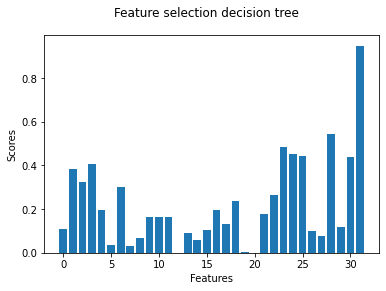

In [18]:
# Make a x and y from the dataset
x = ml_datasetenergy02[['CPI_energy1year', 'Sunhoursdaily1year', 'TG1year', 'TX1year', 'TN1year','FG_x1year','FG_y1year', 'CPI_energy2month', 'Sunhoursdaily2month', 'TG2month', 'TX2month', 'TN2month', 'FG_x2month', 'FG_y2month', 'CPI_energy3month', 'Sunhoursdaily3month', 'TG3month', 'TX3month', 'TN3month', 'FG_x3month', 'FG_y3month', 'CPI_energy6month', 'Sunhoursdaily6month', 'TG6month', 'TX6month', 'TN6month', 'FG_x6month', 'FG_y6month','Energyconsumption2month', 'Energyconsumption3month', 'Energyconsumption6month','Energyconsumption1year']]
y = ml_datasetenergy02['Energyconsumption']

# Split the dataset in training- and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1)

# Make the regressionmodel 
regressionmodel = LinearRegression() # Make the linear regressionmodel
regressionmodel.fit(x_train, y_train) # Fit the model

# Define the feature selection 
def select_features(x_train, y_train, x_test):
    feature_selection01 = SelectKBest(score_func=mutual_info_regression, k='all') # Get all the features
    feature_selection01.fit(x_train, y_train) # Important: see the relationship (learning) in the training data
    x_train_feature_selection01 = feature_selection01.transform(x_train) # Convert the train input data
    x_test_feature_selection01 = feature_selection01.transform(x_test) # Convert the test input data
    return x_train_feature_selection01, x_test_feature_selection01, feature_selection01 # Return the converted data

# Get the feature selection
x_train_feature_selection01, x_test_feature_selection01, feature_selection01 = select_features(x_train, y_train, x_test)

# Get the scores of the features
for columns, score, i in zip(x.columns, feature_selection01.scores_, range(len(feature_selection01.scores_))): # Create a zip because of the multiple variables
    print('Feature %d: %s - %f' % (i, columns, score)) # Print as Feature, number of feature (0-31), feature name and score

# Show the scores in a plot

fig = plt.figure()

plt.bar([i for i in range(len(feature_selection01.scores_))], feature_selection01.scores_) # Create a function in the plotbar that shows the scores and the number of the feature. 

fig.suptitle('Feature selection decision tree')
plt.xlabel('Features')
plt.ylabel('Scores')

plt.show()


#### Conclusion feature selection decision tree

Interestingly, the features based on correlation are almost the same as features based on mutual information. However, four are different. These are features 9, 10, 16 and 21, which are included in the decission tree but were not included in linear regression. These are the features below in order of high to low score.

1. Energyconsumption1year
2. TX1year
3. TG6month
4. TX6month
5. Sunhoursdaily1year
6. TN6month
7. TG1year
8. Sunhoursdaily6month
9. Energyconsumption2month
10. TN1year
11. Energyconsumption6month
12. FG_y1year
13. TG3month
14. CPI_energy6month
15. TX2month
16. TN3month
17. TG2month

#### Prediction with the 17 best features

In [19]:
# Import packages 
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

# Create a x and y for the prediction. x is with the best 17 features
x = ml_datasetenergy02[['Energyconsumption1year', 'TX1year', 'TG6month', 'TX6month', 'Sunhoursdaily1year', 'TN6month', 'TG1year', 'Sunhoursdaily6month', 'Energyconsumption2month', 'TN1year', 'Energyconsumption6month', 'FG_y1year', 'TG3month', 'CPI_energy6month', 'TX2month', 'TN3month', 'TG2month']]
y = ml_datasetenergy02['Energyconsumption']  # target variable

# Make a train- and test set
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.35, random_state = 0)

# Create the model
x_standard_scaler = StandardScaler()
x_train = x_standard_scaler.fit_transform(x_train)

regrassor = DecisionTreeRegressor(random_state = 0)
regrassor.fit(x_train, y_train)

prediction_decisiontree = regrassor.predict(x_standard_scaler.transform(x_test))

# Evualate the model
print(mean_squared_error(y_test, prediction_decisiontree)**(1/2))
print(r2_score(y_test, prediction_decisiontree))

237.00199117354418
0.842081681499296


#### Predict with all the features

In addition, decision tree regression is also applied with all features. This allows to see whether the feature selection has optimised the model. 

In [20]:
# Create a x and y for the prediction. x is with all the features
x = ml_datasetenergy02[['CPI_energy1year', 'Sunhoursdaily1year', 'TG1year', 'TX1year', 'TN1year','FG_x1year','FG_y1year', 'CPI_energy2month', 'Sunhoursdaily2month', 'TG2month', 'TX2month', 'TN2month', 'FG_x2month', 'FG_y2month', 'CPI_energy3month', 'Sunhoursdaily3month', 'TG3month', 'TX3month', 'TN3month', 'FG_x3month', 'FG_y3month', 'CPI_energy6month', 'Sunhoursdaily6month', 'TG6month', 'TX6month', 'TN6month', 'FG_x6month', 'FG_y6month','Energyconsumption2month', 'Energyconsumption3month', 'Energyconsumption6month','Energyconsumption1year']]
y = ml_datasetenergy02['Energyconsumption']

# Make a train- and test set
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.34, random_state = 0)

# Create the model
x_standard_scaler01 = StandardScaler()
x_train = x_standard_scaler01.fit_transform(x_train)

regrassor = DecisionTreeRegressor(random_state = 0)
regrassor.fit(x_train, y_train)

prediction_decisiontree01 = regrassor.predict(x_standard_scaler01.transform(x_test))

# Evualate the model
print(mean_squared_error(y_test, prediction_decisiontree01)**(1/2))
print(r2_score(y_test, prediction_decisiontree01))

256.26199347996493
0.8168064277558647


#### Conclusion decision tree regression

Even with the ideal features and number of features, the model does not perform as well as a simple calculation based on last year's energy consumption. This is because the mean squared error is about 237 and should then be lower than 198. The model does perform better than when all features are included. This means that the feature selection did make sense. The model also performed no better than the linear regression model.  

### Random forest regression

In a random forest, multiple decision trees are combined into a random forest. A random forest can potentially offer an advantage in prediction because not all variables are correlated to each other (IBM, z.d.). In a random forest, it is important to address the problem of over-fitting a single decision tree  (Rakhra, 2021). 

In addition, random forest regression is also applied with all features. This allows to see whether the feature selection has optimised the model. 

#### Make a random forest from the 17 features

In [21]:
# Import packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification

# Create a x and y for the prediction. x is with the best 17 features
x = ml_datasetenergy02[['Energyconsumption1year', 'TX1year', 'TG6month', 'TX6month', 'Sunhoursdaily1year', 'TN6month', 'TG1year', 'Sunhoursdaily6month', 'Energyconsumption2month', 'TN1year', 'Energyconsumption6month', 'FG_y1year', 'TG3month', 'CPI_energy6month', 'TX2month', 'TN3month', 'TG2month']]
y = ml_datasetenergy02['Energyconsumption']  # target variable

# Make a train- and test set
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.34, random_state = 0)

# Create the model
random_forest = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18).fit(x_train, y_train)

prediction_random_forest = random_forest.predict(x_test)

# Evualate the model
print(mean_squared_error(y_test, prediction_random_forest)**(1/2))
print(r2_score(y_test, prediction_random_forest))

239.520813735866
0.8399600718065101


In [22]:
# Import packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification

# Create a x and y for the prediction. x is with all the features
x = ml_datasetenergy02[['CPI_energy1year', 'Sunhoursdaily1year', 'TG1year', 'TX1year', 'TN1year','FG_x1year','FG_y1year', 'CPI_energy2month', 'Sunhoursdaily2month', 'TG2month', 'TX2month', 'TN2month', 'FG_x2month', 'FG_y2month', 'CPI_energy3month', 'Sunhoursdaily3month', 'TG3month', 'TX3month', 'TN3month', 'FG_x3month', 'FG_y3month', 'CPI_energy6month', 'Sunhoursdaily6month', 'TG6month', 'TX6month', 'TN6month', 'FG_x6month', 'FG_y6month','Energyconsumption2month', 'Energyconsumption3month', 'Energyconsumption6month','Energyconsumption1year']]
y = ml_datasetenergy02['Energyconsumption']

# Make a train- and test set
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.34, random_state = 0)

# Create the model
random_forest = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18).fit(x_train, y_train)

prediction_random_forest = random_forest.predict(x_test)

# Evualate the model
print(mean_squared_error(y_test, prediction_random_forest)**(1/2))
print(r2_score(y_test, prediction_random_forest))

247.07125124302587
0.8297111313314719


#### Conclusion random forest regression

It is very strange that the random forest almost performs equally well with both. Therefore, grid research may have to take place to optimise the hyper parameters (Menon, 2022). However, it does not yet come close to linear regression. So that will not happen at this time. Several ways have been tried to change the hyper parameters. However, this did not result in a higher mean squared error. 

## Conclusion and recommendations

### The mean conclusion and some recommendations

Much research has been done on predicting energy consumption. However, most studies are related to predicting the energy consumption of buildings or houses. This includes many parameters about the building or house. Think size, number of rooms, number of windows and people. But some studies went further and also looked at air-conditioning systems and type of heating. These the researchers called technical data (Ying, 2021). This study worked with weather and financial data (inflation). However, these researchers had more data (daily) and so could predict much more specifically with the features they had (Zhao, 2019). This was a key problem from this study, which was conducted with monthly data. 

As a result, no better mean squared error came out than a simple calculation based on the previous year's energy consumption. However, if more data were available, the linear regression model would probably have worked best. In this case, some points had to be changed. Here, the availability of daily data is assumed rather than hourly. 

* First, the time series had to go back to two, three days and one week. However, a year back is still very interesting too. Because there can now be much more focused forecasts on a day. It was chosen not to do a day in advance, for the same reason as a month in advance with the current dates. 

* Second, the model would be much more concrete if it was on a household-by-household basis, because then households could be classified first. This turned out to be a big improvement to the model from another study for energy consumption (Leysen, 2016).  

* Finally, for bigger buildings, air conditioners, freezers and light do turn out to be more important features than for households. For example, at a supermarket (M.R Braun, 2014). Therefore, forecasting for households will be easier than for buildings or businesses. 

### The ethical issue around the data

The biggest problem of the study was mentioned above and that was the lack of data. However, a new study was conducted on this and this was found to be a problem in the laws and regulations of the Netherlands. 

This showed that this data is there, but this data should not be used by energy suppliers, however, as it violates the privacy of personal data. This is because of the General Data Protection Regulation, also known as the AVG. However, according to the AVG, this data may be used if the person gives permission. The problem, however, is that this then comes into conflict with the Electricity and Gas Act. According to this act, this data cannot be shared because of protection against competition and a duty of confidentiality applies (because of household privacy) (Overheid.nl, z.d.).

This lead to an examination of the ethical dilemma: 

"Can household privacy be violated if it benefits sustainability?"

For interest in this research, please refer to my GitHub page: https://github.com/riksmink/HCAI-RoyalHaskoningDHV. 

## Legend features

Word:      | Description:
-----------|------------
CPI:       |Consumer price index
TG:        |Mean temperature
TN:        |Maximum temperature
TX:        |Minimum temperature
TG_y:      |Wind strenght mean
TG_x:      |Wind strenght mode

## Sources:

* Brownlee, J. (2020, juni 8). How to Perform Feature Selection for Regression Data. Retrieved 17 oktober, 2022, from Machine Learning Mastery: https://machinelearningmastery.com/feature-selection-for-regression-data/
* Buijze, A. (2021). “Power to the People”. Utrecht: Universiteit Utrecht.
* Ding, Y. (2021). Energy & Buildings. Energy and Buildings.
* Fernando, J. (2021, september 12). R-Squared Formula, Regression, and Interpretations. Retrieved oktober 21, 2022, from Investopedia: https://www.investopedia.com/terms/r/r-squared.asp
* Het Weer. (2022, z.d. z.d.). Invloed van het weer op de energierekening. Retrieved oktober 16, 2022, from Het Weer: https://hetweermagazine.nl/artikelen/invloed-van-het-weer-op-de-energierekening#:~:text=Als%20de%20buitentemperatuur%20gemiddeld%20hoger,zon%20en%20mate%20van%20isolatie.
* Heyes, A. (2022, mei 27). Understanding Purchasing Power and the Consumer Price Index. Retrieved september 29, 2022, from Investopedia: https://www.investopedia.com/terms/p/purchasingpower.asp
* IBM. (2020, december 7). Random Forest. Retrieved oktober 7, 2022, from IBM: https://www.ibm.com/cloud/learn/random-forest
* Jim Frost. (z.d., z.d. z.d.). Mean Squared Error (MSE). Retrieved oktober 21, 2022, from Statistics By Jim: https://statisticsbyjim.com/regression/mean-squared-error-mse/
* Kamer, T. (2022, mei 22). Debat over de ontwikkeling van de koopkracht en de stijgende energieprijzen, eerste termijn Kamer. Retrieved september 20, 2022, from Tweede Kamer: https://www.tweedekamer.nl/kamerstukken/plenaire_verslagen/kamer_in_het_kort/debat-over-de-ontwikkeling-van-de-koopkracht-en-de
* Knaub, J. R. (2015). When Prediction is Not Time Series Forecasting. ResearchGate.
* KNMI. (z.d., z.d. z.d.). Windschaal van Beaufort. Retrieved september 19, 2022, from KNMI: https://www.knmi.nl/kennis-en-datacentrum/uitleg/windschaal-van-beaufort
* Leysen, C. (2016). Energieverbruik voorspellen en clusteren met Gaussiaanse processen. Leuven: KU Leuven.
* M.R Braun, H. S. (2014, Juni 13). Using regression analysis to predict the future energy consumption of a supermarket in the UK. Applied Energy.
* Maulud, D. H. (2020). A Review on Linear Regression Comprehensive in Machine Learning. Duhok: Journal of Applied Science and Technology Trends.
* Menon, K. (2022, augustus 2). Everything You Need to Know About Feature Selection In Machine Learning. Retrieved oktober 24, 2022, from Simplilearn: https://www.simplilearn.com/tutorials/machine-learning-tutorial/feature-selection-in-machine-learning#:~:text=Feature%20Selection%20is%20the%20method,you%20are%20trying%20to%20solve.
* Overheid.nl. (z.d., z.d. z.d.). Juridische kaders rondom het delen van energiedata. Retrieved oktober 19, 2022, from Overheid.nl: https://data.overheid.nl/juridische-kaders-rondom-het-delen-van-energiedata#_Verdiepende_achtergrondinformatie
* Peri, G. (2019, mei 2). Pipeline for feature selection — Scikit-Learn. Retrieved oktober 26, 2022, from Medium: https://medium.com/@GouthamPeri/pipeline-with-tuning-scikit-learn-b2789dca9dc2#:~:text=Pipelines%20are%20used%20to%20sequentially,this%20is%20called%20feature%20selection.
* Rakhra, M. (2021, maart 10). Crop Price Prediction Using Random Forest and Decision Tree Regression:-A Review. Materials today proceedings.
* Rijksoverheid. (2022, september 16). Nederland maakt ambitie wind op zee bekend: 70 gigawatt in 2050. Retrieved september 19, 2022, from Rijksoverheid: https://www.rijksoverheid.nl/actueel/nieuws/2022/09/16/nederland-maakt-ambitie-wind-op-zee-bekend-70-gigawatt-in-2050
* Seldon. (2021, november 13). Decision Trees in Machine Learning Explained. Retrieved oktober 19, 2022, from Seldon: https://www.seldon.io/decision-trees-in-machine-learning#:~:text=Decision%20trees%20are%20an%20approach,categorise%20or%20classify%20an%20object.
* Solutions, S. (z.d., z.d. z.d.). What is Linear Regression? Retrieved oktober 19, 2022, from Statistics Solutions: https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/what-is-linear-regression/
* Visser, M. (2014). Duurzaam Groningen in 2035. Groningen: Hanze University of Applied Sciences .
* Weezel, T. G. (2022, mei 30). Recordreeks van groene stroom leidt tot nieuwe problemen voor producenten en netbeheerder. Retrieved september 20, 2022, from de Volkskrant: volkskrant.nl/economie/recordreeks-van-groene-stroom-leidt-tot-nieuwe-problemen-voor-producenten-en-netbeheerder~b707ed72/?referrer=https%3A%2F%2Fwww.google.com%2F
* Wolters, D. (2011). Ruimtelijke klimatologische verschillen binnen Nederland. De Bilt: KNMI.
* Zhao, D. (2019). Effective Features to Predict Residential Energy Consumption Using Machine Learning. Michigan: ResearchGate.

